In [1]:
#這是InceptionV3遷移學習
#這是functional-API寫法

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
#繼承之前練習的圖片

from glob2 import glob
from sklearn.model_selection import train_test_split

shrine = glob('./img/shrine_temple/train/shrine/*.jpg')
temple = glob('./img/shrine_temple/train/temple/*.jpg')

shrine_train, shrine_test = train_test_split(shrine, test_size=0.30)
temple_train, temple_test = train_test_split(temple, test_size=0.30)

TRAIN_DIR = 'img/shrine_temple/train'
TEST_DIR = 'img/shrine_temple/train'

In [4]:
#看一下圖片

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

shrine = np.random.choice(shrine_train, 13)
temple = np.random.choice(temple_train, 12)
data = np.concatenate((shrine,temple))
labels = 13 * ['shrine'] + 12 *['temple']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [5]:
#自定義網路
#遷移學習，採用InceptionV3網路

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
#建立不帶分類器的訓練模型
#因為分類項目是我們自己定義，這就是遷移學習
base_model = InceptionV3(weights='imagenet', include_top=False)


#定義global參數
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
#遷移學習模型
for layer in base_model.layers:
    layer.trainable = False

#最佳化函數為rmsprop
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
#Data augmentation

from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


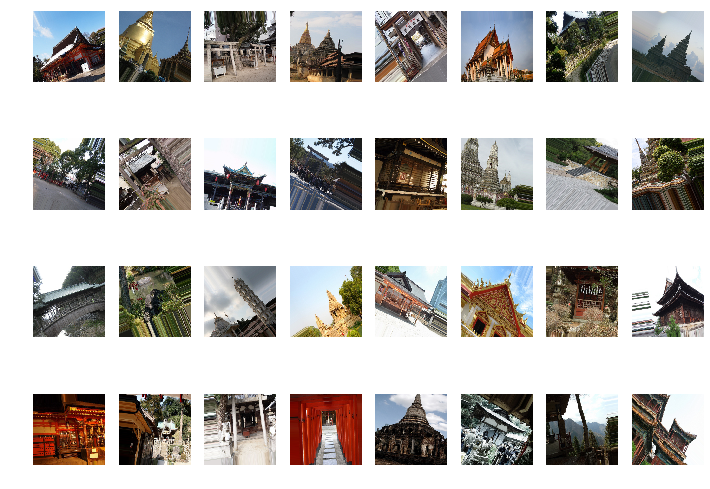

In [12]:
#看一下Data augmentation的成果
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [10]:
#模型學習開始
#儲存模型InceptionV3-transfer-learning.model

EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'InceptionV3-transfer-learning.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
320/320 [==============================] - 309s 965ms/step - loss: 0.4439 - acc: 0.7835 - val_loss: 1.1227 - val_acc: 0.6364
Epoch 2/5
320/320 [==============================] - 290s 906ms/step - loss: 0.3539 - acc: 0.8455 - val_loss: 0.4647 - val_acc: 0.8221
Epoch 3/5
320/320 [==============================] - 289s 902ms/step - loss: 0.3163 - acc: 0.8657 - val_loss: 0.5537 - val_acc: 0.7986
Epoch 4/5
320/320 [==============================] - 291s 908ms/step - loss: 0.3136 - acc: 0.8656 - val_loss: 0.5382 - val_acc: 0.8029
Epoch 5/5
320/320 [==============================] - 289s 904ms/step - loss: 0.3104 - acc: 0.8681 - val_loss: 0.4548 - val_acc: 0.8335


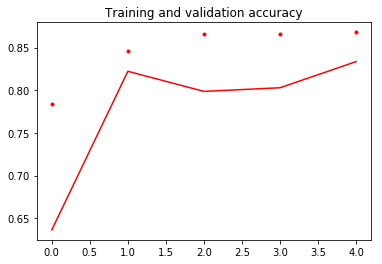

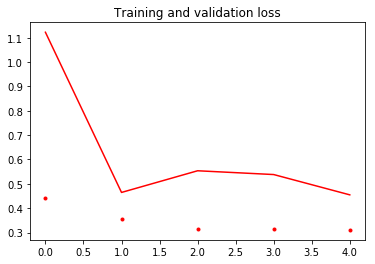

In [13]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("shrine", "temple")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [18]:
#讀取模型
#這種寫法是functional-API，因此讀取模型時候不會出錯

model_new=load_model(MODEL_FILE)

array([9.9981254e-01, 1.8747627e-04], dtype=float32)

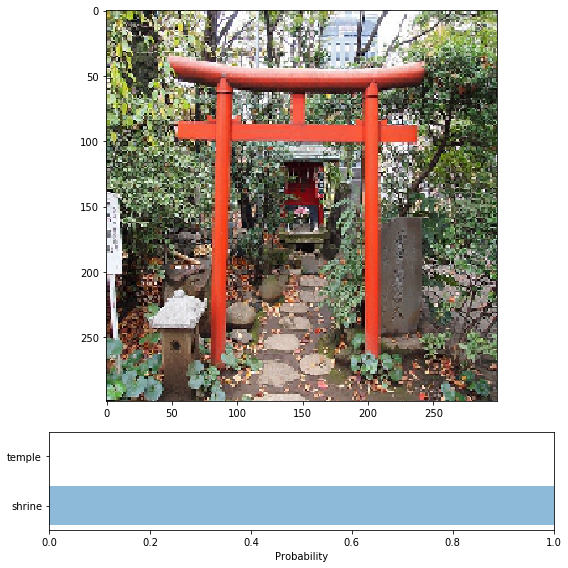

In [20]:
#這是用剛剛讀取的模型預測的

img = image.load_img('img/shrine_temple/test/unknown/shrine_4353891134_8e25e4418c.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model_new, img)

plot_preds(np.asarray(img), preds)
preds